# ADSP common deletion CNV data report

## Load reference genes and common deletion CNV data

**Notes**:
- ADSP: Alzheimer's Disease Sequencing Project
- Reference genes: hg19 reference genes from UCSC
- `hq` within the CNV data file name means "high qulaity"

In [1]:
import pandas as pd
import numpy as np
import os
from collections import Counter
import matplotlib.pyplot as plt

# Load data
cwd = os.path.expanduser("~/cnv-project/adsp_real_data")
ref_gene = pd.read_csv(f"{cwd}/refGene.clean.gz", compression = "gzip", sep = "\t", header = 0)
del_comm_cnv = pd.read_csv(f"{cwd}/raw_data/del_comm_adsp_hq.gz", compression="gzip", sep="\t")
del_comm_cnv = del_comm_cnv.drop(columns=["COUNTED","ALT"])
del_comm_cnv.iloc[:,0] = del_comm_cnv.iloc[:,0].str.replace('chr','')

In [2]:
# Preview of CNV data
del_comm_cnv.head(3)

,CHR,SNP,CM,POS,0:A-ACT-AC000014-BL-NCR-15AD78694,0:A-ACT-AC000034-BL-NCR-16AD84906,0:A-ACT-AC000057-BL-NCR-15AD78356,0:A-ACT-AC000072-BL-NCR-15AD77250,0:A-ACT-AC000088-BL-NCR-15AD76548,0:A-ACT-AC000092-BL-NCR-15AD78589,...,0:G-MSBB-MB000331-BR-MSBB-71993,0:G-MSBB-MB000332-BR-MSBB-71994,0:G-MSBB-MB000333-BR-MSBB-71995,0:G-MSBB-MB000334-BR-MSBB-71996,0:G-MSBB-MB000335-BR-MSBB-74458,0:G-MSBB-MB000337-BR-MSBB-76349,0:G-MSBB-MB000338-BR-MSBB-76350,0:G-MSBB-MB000339-BR-MSBB-76351,0:G-MSBB-MB000340-BR-MSBB-76352,0:G-MSBB-MB000341-BR-MSBB-76353
0,22,chr22:10710932-10711692:DEL:COVERAGE:comm,10710932,10711692,1.0,0.0,1.0,1.0,1.0,0.0,...,NaN,1.0,1.0,1.0,1.0,0.0,1.0,NaN,1.0,1.0
1,22,chr22:10720746-10721165:DEL:COVERAGE:comm,10720746,10721165,1.0,1.0,1.0,NaN,1.0,1.0,...,1.0,1.0,NaN,1.0,NaN,1.0,1.0,1.0,1.0,1.0
2,22,chr22:10740324-10746330:DEL:AGGREGATED:comm,10740324,10746330,0.0,0.0,0.0,NaN,0.0,NaN,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Explanation**:

- Each row represents CNVs and each column starting from the fifth column means individuals
- "CM", "POS": Start point and end point of a CNV, respectively.
- "0:A-ACT-xxxxx": sample_id for an individual

In [3]:
# Preview of ref_gene
ref_gene.head(3)

,CHR,start,end,gene
0,1,11868,14362,LOC102725121@1
1,1,11873,14409,DDX11L1
2,1,14361,29370,WASH7P


## Distribution of NA values 

- This is a simple step for quality control even if the CNV data has a "high quality". 
- The goal for this step is for finding an appropraite cutoff for removing individuals having high proportion of NAs across their genomes.

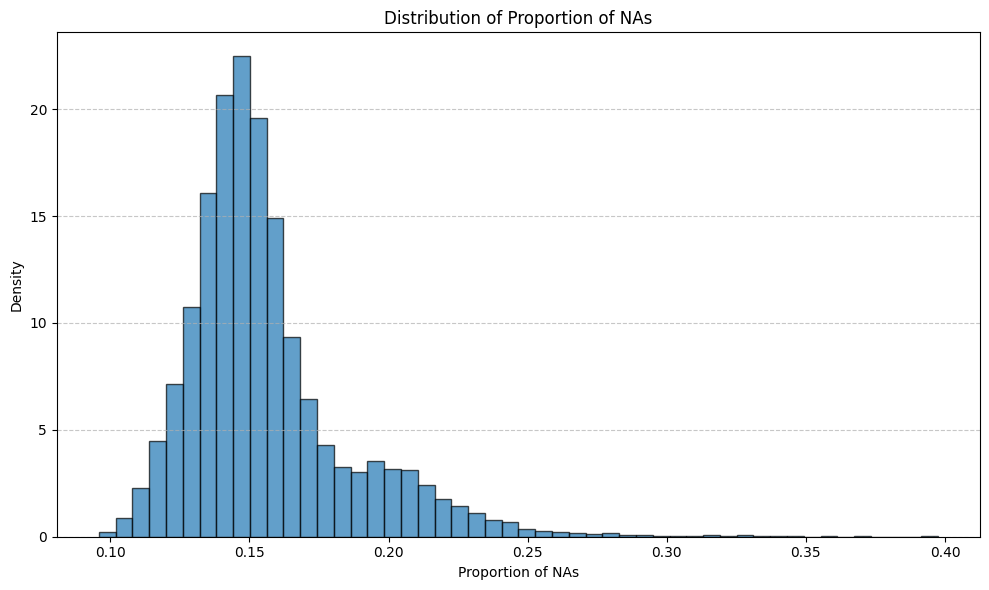

In [8]:
individuals = del_comm_cnv.columns[4:]
prop_na_list = [del_comm_cnv[indv].isna().sum() / del_comm_cnv.shape[0] for indv in individuals]

# Plot distribution for proportions of NAs 
plt.figure(figsize=(10, 6))
plt.hist(prop_na_list, bins=50, edgecolor='black', alpha=0.7, density=True)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlabel("Proportion of NAs")
plt.ylabel("Density")
plt.title("Distribution of Proportion of NAs")
plt.tight_layout()  
plt.show()

In [11]:
# Percentiles for the proportions
for p in [10, 25, 50, 75, 90]:
    value = np.percentile(prop_na_list, p)
    print(f"{p}th percentile: {np.round(value,3)}")

10th percentile: 0.127
25th percentile: 0.138
50th percentile: 0.15
75th percentile: 0.165
90th percentile: 0.198


**Conclusion**: We decide to remove individuals having more than 20% NAs (in a column).

In [14]:
cutoff = 0.2
indv_to_keep = [index for index, element in enumerate(prop_na_list) if element <= cutoff]
del_comm_cnv = del_comm_cnv.iloc[:,indv_to_keep]

# Divide CNV data into 2 parts: 
# CNV events: First 4 columns and 
# individuals: "SNP" column and rest of sample IDs 
cnv_events = del_comm_cnv[["CHR","SNP","CM","POS"]]
cnv_indvs = del_comm_cnv.iloc[:,[1,*range(4,del_comm_cnv.shape[1])]] 

## Summary of CNV data

In [15]:
# Add a column printing the size of a CNV event
pd.set_option('mode.chained_assignment', None) # Suppress warning
cnv_events.loc[:, 'size'] = cnv_events['POS'] - cnv_events['CM']
print(cnv_events['size'].describe().round(1))

count       9366.0
mean        4805.6
std        88111.2
min            1.0
25%           81.0
50%          225.0
75%          706.2
max      4950897.0
Name: size, dtype: float64


**Conclusion**: 

- 9,366 CNVs which are common deletions
- Most of CNVs have a short length

In [18]:
# Explore features for each column
cnv_events = cnv_events.sort_values(by = ['CHR','CM','POS'])
print(f"Chromosomes are: {cnv_events['CHR'].unique()}")
print("Are START points for each CNV in all chromosomes sorted in ascending order? -> ",
      all([(cnv_events[cnv_events['CHR'] == f'{i}'])['CM'].is_monotonic_increasing for i in cnv_events['CHR'].unique()])
     )
print("Are END points for each CNV in all chromosomes sorted in ascending order? -> ",
      all([(cnv_events[cnv_events['CHR'] == f'{i}'])['POS'].is_monotonic_increasing for i in cnv_events['CHR'].unique()])
     )

Chromosomes are: ['1' '10' '11' '12' '13' '14' '15' '16' '17' '18' '19' '2' '20' '21' '22'
 '3' '4' '5' '6' '7' '8' '9']
Are START points for each CNV in all chromosomes sorted in ascending order? ->  True
Are END points for each CNV in all chromosomes sorted in ascending order? ->  False


## Partition whole genome into blocks

- In our simulation, we divide the whole genome into blocks for reducing computational burden.

**Rules**:
- A block contains CNV events overlapping with each other.
- Any CNV in two seperate blocks don't overlap with each other. 

In [19]:
def is_overlapping(row1, row2):
    return (row1["CM"] >= row2["CM"] and row1["CM"] <= row2["POS"]) or \
           (row1["CM"] <= row2["CM"] and row1["POS"] >= row2["POS"]) or \
           (row1["POS"] >= row2["CM"] and row1["POS"] <= row2["POS"])

def partition_into_blocks(df):
    df = df.sort_values(by="CM").reset_index(drop=True)
    blocks = []
    current_block = [df.iloc[0]]

    for i in range(1, len(df)):
        row = df.iloc[i]
        
        # Check if current row overlaps with all rows in current block
        if all(is_overlapping(row, block_row) for block_row in current_block):
            current_block.append(row)
        else:
            blocks.append(current_block)
            current_block = [row]
    
    if current_block:  # Add any remaining rows in the current block to the blocks list
        blocks.append(current_block)

    # Convert list of dataframes to a list of indices
    blocks = [[row.name for row in block] for block in blocks]

    return df, blocks

cnv_sorted, blocks = partition_into_blocks(cnv_events)

In [20]:
# Quick view of block sizes
block_sizes = [len(block) for block in blocks]
Counter(block_sizes)

Counter({1: 8061, 2: 560, 3: 48, 4: 8, 9: 1})

### Distribution of block sizes

- Block size: number of CNVs in a block

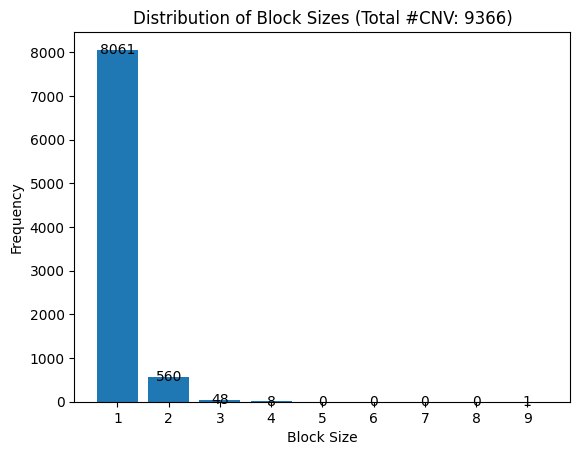

In [21]:
import matplotlib.pyplot as plt

# Get the sizes of each block
block_sizes = [len(block) for block in blocks]

# Plot the histogram
fig, ax = plt.subplots()
n, bins, patches = ax.hist(block_sizes, bins=range(1, max(block_sizes) + 2), align='left', rwidth=0.8)
plt.xlabel('Block Size')
plt.ylabel('Frequency')
plt.title(f'Distribution of Block Sizes (Total #CNV: {cnv_sorted.shape[0]})')
plt.xticks(range(1, max(block_sizes) + 1))

# Adding counts above each bar
for i, patch in enumerate(patches):
    height = patch.get_height()
    ax.text(patch.get_x() + patch.get_width() / 2., height + 0.3, 
            f'{int(height)}', ha='center', va='center')

#plt.savefig(f"{cwd}/dist_blk_size.png", format='png')
plt.show()



### Distribution of block coverage

- Number of genes disrupted by CNVs in a block

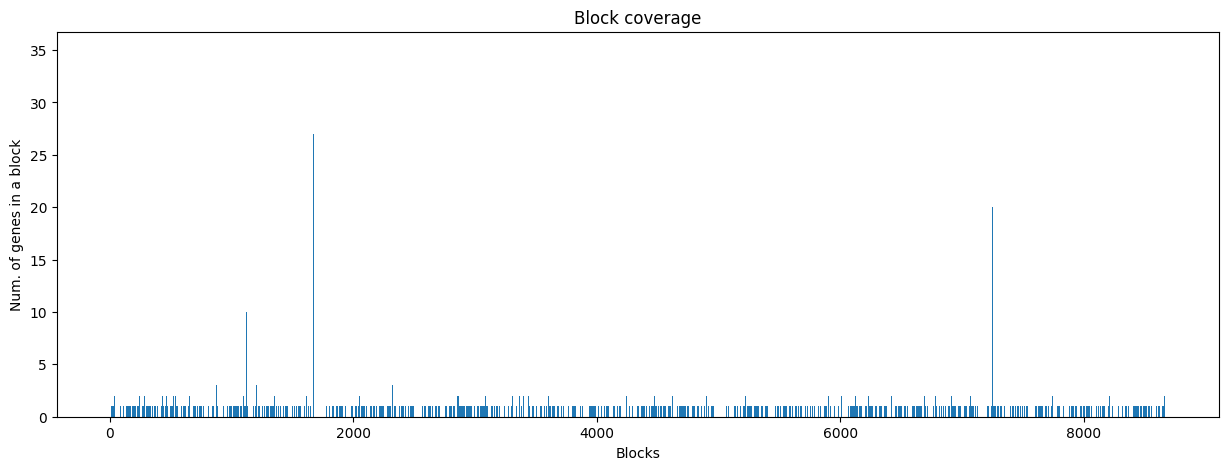

In [22]:
ref_gene = ref_gene[ref_gene['CHR'] != 'X'] # Since CNV data doesn't have sex chromosome,we drop X chr in ref_gene

def genes_in_block(genes, block):
    cnv = cnv_sorted.iloc[block]
    df = cnv.merge(genes, on='CHR', how='left')
    res = df[(df['CM'] >= df['start']) & (df['CM'] <= df['end'])
            |(df['POS'] >= df['start']) & (df['POS'] <= df['end'])
            |(df['CM'] <= df['start']) & (df['POS'] >= df['end'])
            ]
    return(len(res['gene'].unique()))

num_gene_in_block = [genes_in_block(ref_gene, blk) for blk in blocks]


plt.figure(figsize=(15, 5))  # Adjust the figure size for better visualization
plt.bar(list(range(len(blocks))), num_gene_in_block, width=1)
plt.xlabel('Blocks')
plt.ylabel('Num. of genes in a block')
plt.title('Block coverage')
#plt.savefig(f"{cwd}/dist_blk_cvg.png", format='png')
plt.show()

We can see very few number of blocks having many genes inside it, and most of blocks have 1 or no gene. Thus, we have a large number of blocks and the computation burden cannot be reduced under this setting. In other words, ADSP data is unlikely a good fit to our method.